In [95]:
import pickle
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory, mappability_threshold, normalization, iterations
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import os
import matplotlib.colors as mcolors
import textwrap


# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging 
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]

# Debug print to check the value of resolution_str
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, resolution_label = parse_resolution(resolution_str)

# Load original_bulk_data from the file
bulk_data_input_file = '../../projects/single_cell_files/nan_removed_bulk_data.pkl'
with open(bulk_data_input_file, 'rb') as f:
    bulk_data = pickle.load(f)
print(f"bulk_data loaded from {bulk_data_input_file}")

# Load original_bulk_data from the file
original_bulk_data_input_file = '../../projects/single_cell_files/original_bulk_data.pkl'
with open(original_bulk_data_input_file, 'rb') as f:
    original_bulk_data = pickle.load(f)
print(f"original_bulk_data loaded from {bulk_data_input_file}")

# Load chromosome_results from the file
chromosome_results_input_file = '../../projects/single_cell_files/chromosome_results.pkl'
with open(chromosome_results_input_file, 'rb') as f:
    chromosome_results = pickle.load(f)
print(f"chromosome_results loaded from {chromosome_results_input_file}")

########################################################################
#compute the genome-wide correlation of the two AB compartment cell types
# should be somehting like .6 if all the above steps were done correctly
# this is a sanity check
# There seems to be a problem here
# I beleive the issue is that without KR normalization, 
# the genome wide correlation of bulk is not that high
########################################################################
# Initialize lists to collect the eigenvector values for IMR90 and GM12878
imr90_values = []
gm12878_values = []

# Loop through each chromosome
for i in range(1, 23):
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_{normalization}_eigenvector'
    key_imr90 = f'res{resolution}_ch{i}_oe_IMR90_{normalization}_eigenvector'                                                               
                                                               
    # Check if the keys exist in the data to avoid KeyErrors
    if key_gm12878 in bulk_data and key_imr90 in bulk_data:
        # Extend the list with the eigenvector values from each chromosome
        # Ensure values are numeric (floats or ints)
        gm12878_vals = bulk_data[key_gm12878]['eigenvalue']
        imr90_vals = bulk_data[key_imr90]['eigenvalue']
        imr90_values.extend(imr90_vals)
        gm12878_values.extend(gm12878_vals)
        
# Convert lists to pandas Series for correlation calculation
imr90_series = pd.Series(imr90_values)
gm12878_series = pd.Series(gm12878_values)

# Calculate the Pearson correlation coefficient between IMR90 and GM12878
genome_wide_correlation = imr90_series.corr(gm12878_series)

print(f'Genome-wide correlation between IMR90 and GM12878: {genome_wide_correlation}')



Resolutions from config: ('1000000:1Mb',)
Extracted resolution string: 1000000:1Mb
bulk_data loaded from ../../projects/single_cell_files/nan_removed_bulk_data.pkl
original_bulk_data loaded from ../../projects/single_cell_files/nan_removed_bulk_data.pkl
chromosome_results loaded from ../../projects/single_cell_files/chromosome_results.pkl
Genome-wide correlation between IMR90 and GM12878: 0.6687364447778326


In [96]:
def calculate_average_correlations_from_precomputed(chromosome_results, chromosomes):
    gm12878_avg_correlations = {}
    imr90_avg_correlations = {}
    gm12878_avg_correlations_withIMR90 = {}
    imr90_avg_correlations_withGM12878 = {}
    
    for chr in chromosomes:
        # Access the specific chromosome data
        sc_dataframe = chromosome_results[f'chr{chr}']

        # Extract correlations for GM12878
        gm12878_corr_bulk = sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['Correlation With Bulk']
        gm12878_avg_correlations[chr] = gm12878_corr_bulk.mean()
        gm12878_corr_withIMR90 = sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['Correlation With Other Bulk']
        gm12878_avg_correlations_withIMR90[chr] = gm12878_corr_withIMR90.mean()
        
        # Extract correlations for IMR90
        imr90_corr_bulk = sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['Correlation With Bulk']
        imr90_avg_correlations[chr] = imr90_corr_bulk.mean()
        imr90_corr_withGM12878 = sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['Correlation With Other Bulk']
        imr90_avg_correlations_withGM12878[chr] = imr90_corr_withGM12878.mean()

    return gm12878_avg_correlations, imr90_avg_correlations, gm12878_avg_correlations_withIMR90, imr90_avg_correlations_withGM12878

chromosomes = [str(i) for i in range(1, 23)] 
gm12878_avg_corr, imr90_avg_corr, gm12878_avg_correlations_withIMR90, imr90_avg_correlations_withGM12878 = calculate_average_correlations_from_precomputed(chromosome_results, chromosomes)

# Print the results
print("Average correlations for GM12878 with bulk GM12878 and bulk IMR90 by chromosome:")
for chr in chromosomes:
    corr = gm12878_avg_corr[chr]
    corr_other = gm12878_avg_correlations_withIMR90[chr]
    print(f"Chromosome {chr}: {corr:.4f}, {corr_other:.4f}")

print("\nAverage correlations for IMR90 with bulk IMR90 and bulk GM12878 by chromosome:")
for chr in chromosomes:
    corr = imr90_avg_corr[chr]
    corr_other = imr90_avg_correlations_withGM12878[chr]
    print(f"Chromosome {chr}: {corr:.4f}, {corr_other:.4f}")


Average correlations for GM12878 with bulk GM12878 and bulk IMR90 by chromosome:
Chromosome 1: 0.1910, 0.1164
Chromosome 2: 0.1423, 0.1281
Chromosome 3: 0.0917, 0.0070
Chromosome 4: 0.5778, 0.3426
Chromosome 5: 0.2546, -0.1435
Chromosome 6: 0.2919, 0.1754
Chromosome 7: 0.0897, 0.0831
Chromosome 8: 0.1316, 0.1289
Chromosome 9: 0.2623, 0.1558
Chromosome 10: 0.1443, -0.0623
Chromosome 11: 0.1103, 0.0846
Chromosome 12: 0.1650, 0.0809
Chromosome 13: 0.2482, 0.1511
Chromosome 14: 0.2069, 0.1629
Chromosome 15: 0.3760, 0.3506
Chromosome 16: 0.2469, 0.1776
Chromosome 17: 0.1301, 0.1030
Chromosome 18: 0.1764, 0.1549
Chromosome 19: 0.2012, 0.1260
Chromosome 20: 0.2642, 0.2834
Chromosome 21: 0.4277, 0.3628
Chromosome 22: 0.2030, 0.1730

Average correlations for IMR90 with bulk IMR90 and bulk GM12878 by chromosome:
Chromosome 1: 0.1433, 0.2178
Chromosome 2: 0.1415, 0.1285
Chromosome 3: 0.0941, 0.0435
Chromosome 4: 0.3935, 0.6272
Chromosome 5: -inf, -0.1782
Chromosome 6: 0.1830, 0.2583
Chromosome 7:

In [97]:
import numpy as np

def calculate_average_correlations_from_precomputed(chromosome_results, chromosomes):
    gm12878_avg_correlations = []
    imr90_avg_correlations = []
    gm12878_avg_correlations_withIMR90 = []
    imr90_avg_correlations_withGM12878 = []
    
    for chr in chromosomes:
        # Access the specific chromosome data
        sc_dataframe = chromosome_results[f'chr{chr}']

        # Extract correlations for GM12878
        gm12878_corr_bulk = sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['Correlation With Bulk'].mean()
        gm12878_corr_withIMR90 = sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['Correlation With Other Bulk'].mean()
        
        # Extract correlations for IMR90
        imr90_corr_bulk = sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['Correlation With Bulk'].mean()
        imr90_corr_withGM12878 = sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['Correlation With Other Bulk'].mean()

        # Check for -inf values and only include valid correlations
        if not np.isinf(gm12878_corr_bulk):
            gm12878_avg_correlations.append(gm12878_corr_bulk)
        if not np.isinf(gm12878_corr_withIMR90):
            gm12878_avg_correlations_withIMR90.append(gm12878_corr_withIMR90)
        if not np.isinf(imr90_corr_bulk):
            imr90_avg_correlations.append(imr90_corr_bulk)
        if not np.isinf(imr90_corr_withGM12878):
            imr90_avg_correlations_withGM12878.append(imr90_corr_withGM12878)

    # Compute overall averages across all chromosomes, ignoring -inf values
    overall_gm12878_avg_correlation = sum(gm12878_avg_correlations) / len(gm12878_avg_correlations) if gm12878_avg_correlations else np.nan
    overall_imr90_avg_correlation = sum(imr90_avg_correlations) / len(imr90_avg_correlations) if imr90_avg_correlations else np.nan
    overall_gm12878_avg_corr_withIMR90 = sum(gm12878_avg_correlations_withIMR90) / len(gm12878_avg_correlations_withIMR90) if gm12878_avg_correlations_withIMR90 else np.nan
    overall_imr90_avg_corr_withGM12878 = sum(imr90_avg_correlations_withGM12878) / len(imr90_avg_correlations_withGM12878) if imr90_avg_correlations_withGM12878 else np.nan

    return overall_gm12878_avg_correlation, overall_imr90_avg_correlation, overall_gm12878_avg_corr_withIMR90, overall_imr90_avg_corr_withGM12878

chromosomes = [str(i) for i in range(1, 23)] 
overall_gm12878_avg_corr, overall_imr90_avg_corr, overall_gm12878_avg_corr_withIMR90, overall_imr90_avg_corr_withGM12878 = calculate_average_correlations_from_precomputed(chromosome_results, chromosomes)

# Print the overall results
print("Overall average correlations (ignoring -inf):")
print(f"GM12878 with bulk GM12878: {overall_gm12878_avg_corr:.4f}")
print(f"GM12878 with bulk IMR90: {overall_gm12878_avg_corr_withIMR90:.4f}")
print(f"IMR90 with bulk IMR90: {overall_imr90_avg_corr:.4f}")
print(f"IMR90 with bulk GM12878: {overall_imr90_avg_corr_withGM12878:.4f}")


Overall average correlations (ignoring -inf):
GM12878 with bulk GM12878: 0.2242
GM12878 with bulk IMR90: 0.1428
IMR90 with bulk IMR90: 0.2012
IMR90 with bulk GM12878: 0.1900


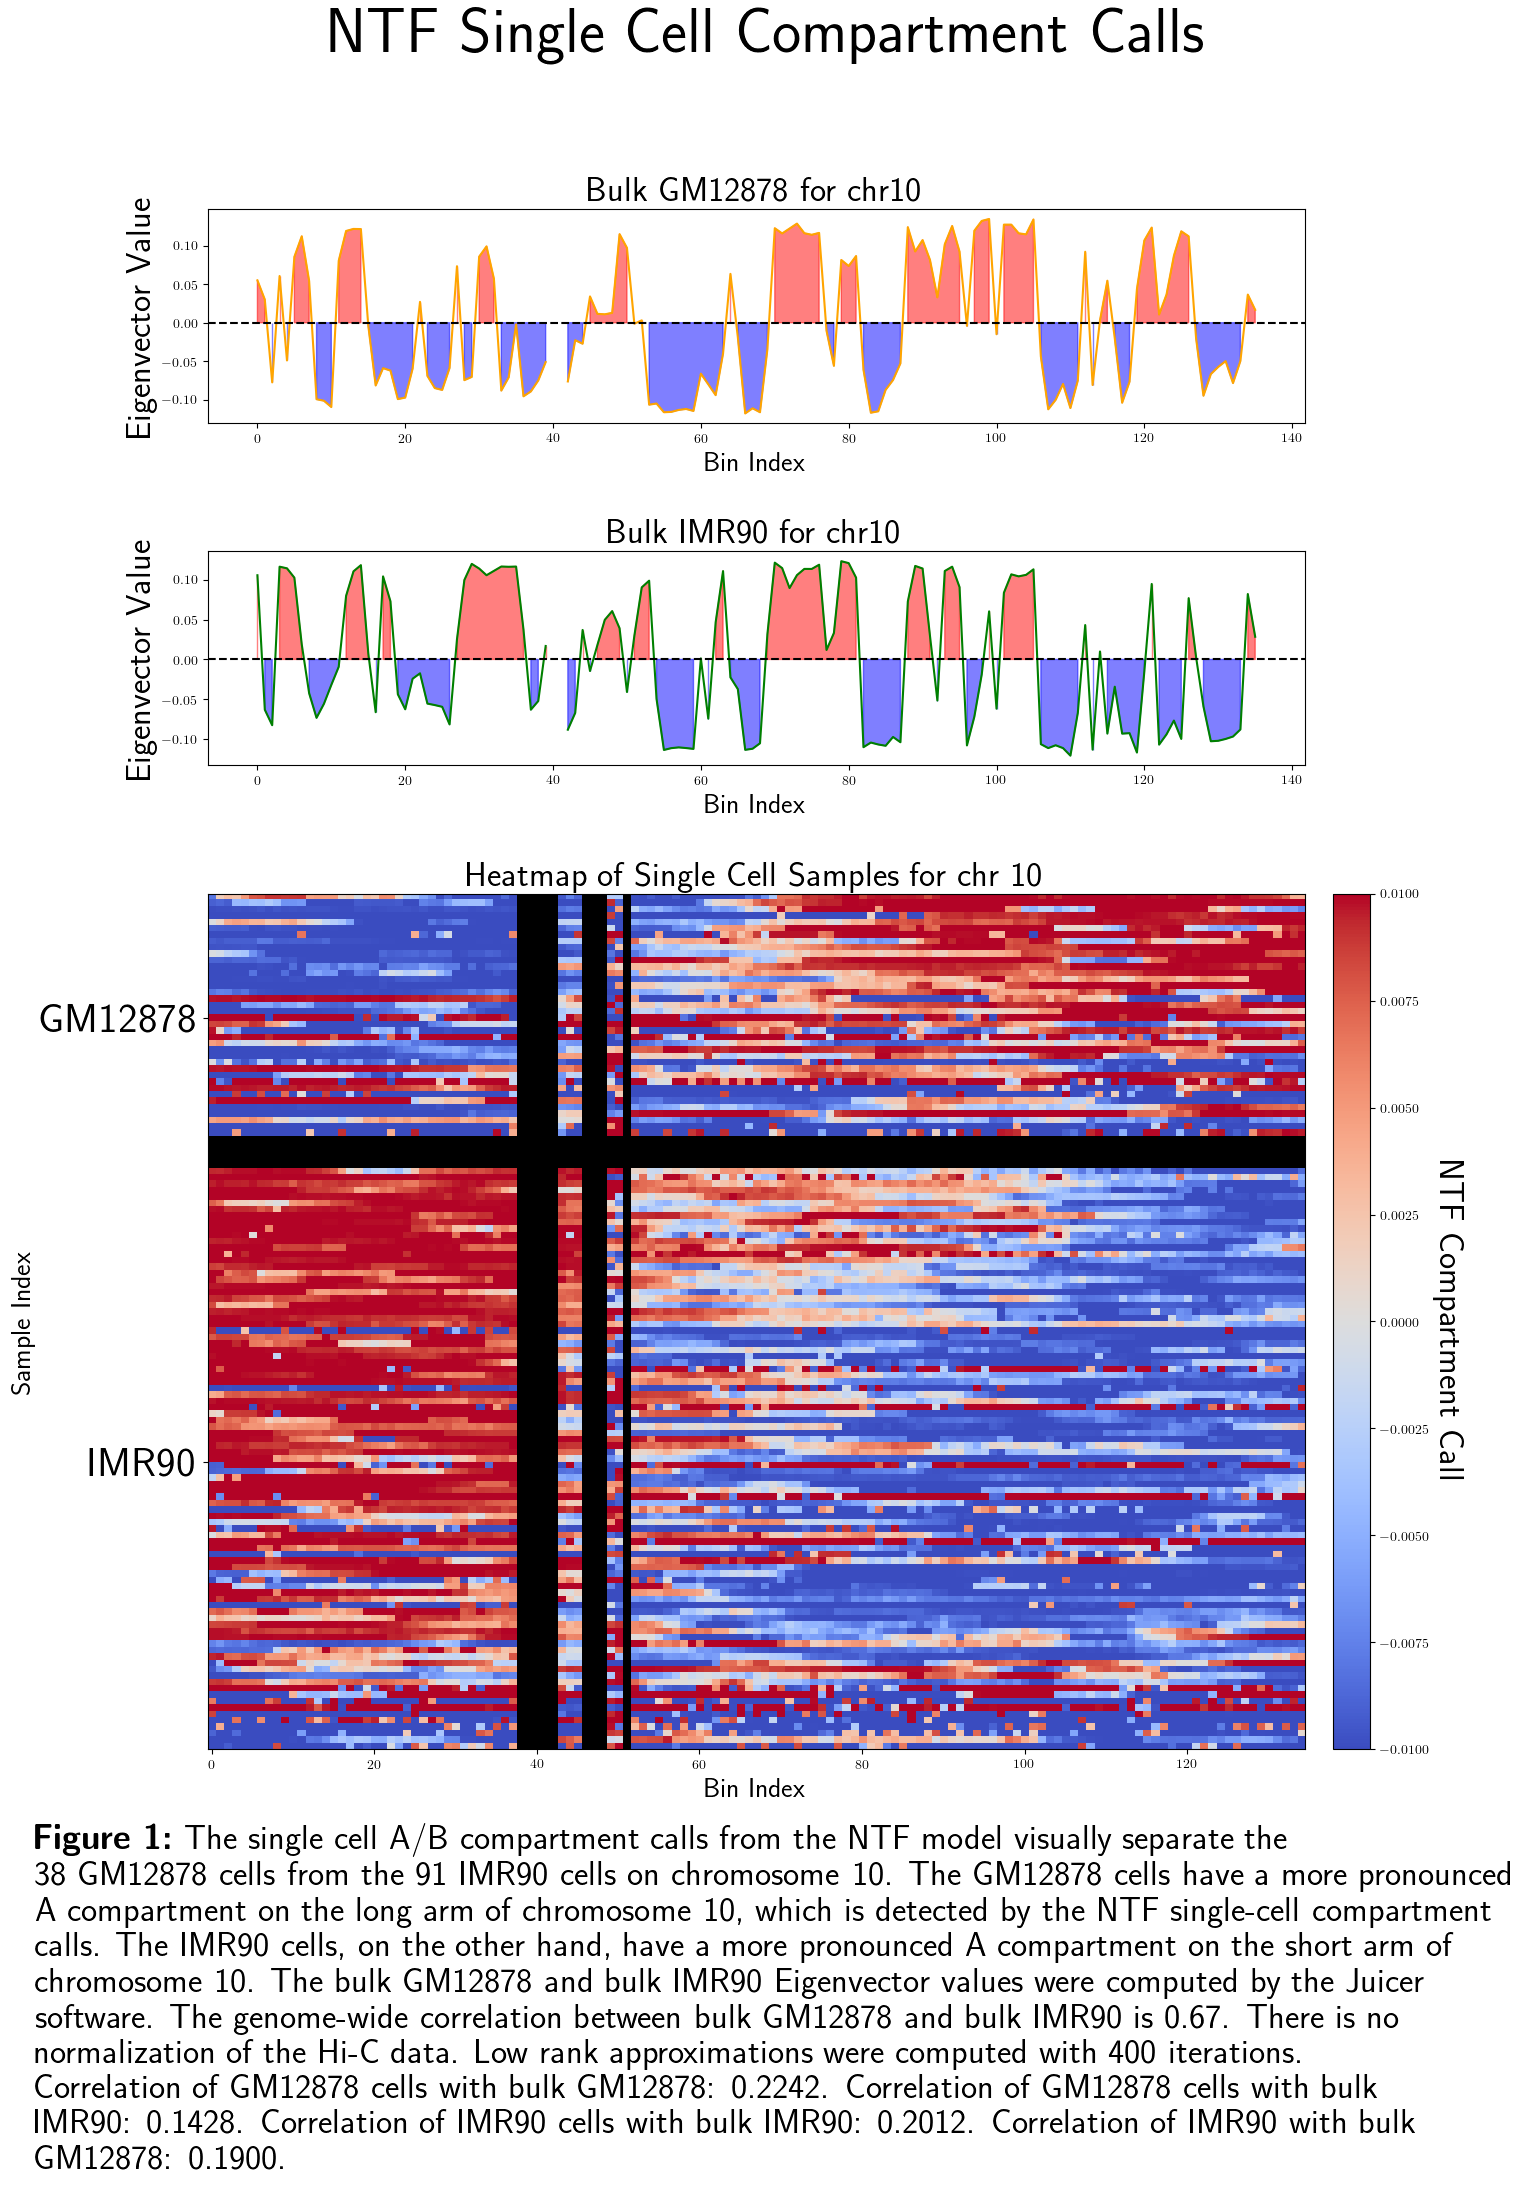

In [141]:
chr = 10
sc_dataframe = chromosome_results[f'chr{chr}']

# Define the bulk eigenvectors
bulk_eigenvector_gm12878 = original_bulk_data[f'res1000000_ch{chr}_oe_GM12878_{normalization}_eigenvector']['eigenvalue'].values
bulk_eigenvector_imr90 = original_bulk_data[f'res1000000_ch{chr}_oe_IMR90_{normalization}_eigenvector']['eigenvalue'].values

# Sort and prepare the dataframe
sc_dataframe['Cell Type Sort'] = sc_dataframe['Cell Type'].map({'GM12878': 0, 'IMR90': 1})
sc_dataframe = sc_dataframe.sort_values(by=['Cell Type Sort', 'Correlation With Bulk'], ascending=[True, False])
sc_dataframe.drop('Cell Type Sort', axis=1, inplace=True)

plt.rcParams['text.usetex'] = True

def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title, correlation, chr, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 20))  # Adjusted the figure size for better proportions
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='orange')
    ax_bulk1.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 >= 0), color='red', alpha=0.5)
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 < 0), color='blue', alpha=0.5)
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=25)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='green')
    ax_bulk2.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 >= 0), color='red', alpha=0.5)
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 < 0), color='blue', alpha=0.5)
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=25)

    gm12878_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    imr90_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    
    empty_rows = np.full((separation_rows, gm12878_data.shape[1]), np.nan)
    sc_data_array = np.vstack([gm12878_data, empty_rows, imr90_data])

    # Create a colormap that does not include white for NaN values
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='black')  # Set NaN color to black

    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap=cmap, interpolation='nearest')  # Use the adjusted colormap
    ax_sc.set_title(f"Heatmap of Single Cell Samples for chr {chr}", fontsize=25)  # Slightly larger font for the title
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    num_gm12878 = len(gm12878_data)
    num_imr90 = len(imr90_data)
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('NTF Compartment Call', rotation=270, labelpad=25, fontsize=25)

    plt.suptitle(title, fontsize=45, fontweight='bold')  

    # Construct the caption
    caption = (r"$\textbf{Figure 1:}$ The single cell A/B compartment calls from the NTF model visually separate the " 
               f"{num_gm12878} GM12878 cells from the {num_imr90} IMR90 cells on chromosome {chr}. "
               f"The GM12878 cells have a more pronounced A compartment on the long arm of chromosome {chr}, which is detected by the "
               f"NTF single-cell compartment calls. The IMR90 cells, on the other hand, have a more pronounced A compartment on the "
               f"short arm of chromosome {chr}. "
               f"The bulk GM12878 and bulk IMR90 Eigenvector values were computed by the Juicer software. "
               f"The genome-wide correlation between bulk GM12878 and bulk IMR90 is {genome_wide_correlation:.2f}. "
               f"There is no normalization of the Hi-C data. Low rank approximations were computed with {iterations} iterations. "
               f"Correlation of GM12878 cells with bulk GM12878: {overall_gm12878_avg_corr:.4f}. "
               f"Correlation of GM12878 cells with bulk IMR90: {overall_gm12878_avg_corr_withIMR90:.4f}. "
               f"Correlation of IMR90 cells with bulk IMR90: {overall_imr90_avg_corr:.4f}. "
               f"Correlation of IMR90 with bulk GM12878: {overall_imr90_avg_corr_withGM12878:.4f}. "
              )

    # Use textwrap to wrap the caption text within a specific width
    wrapped_caption = textwrap.fill(caption, width=100)

    # Add the caption at the bottom with automatic wrapping
    plt.figtext(0.01, -0.1, wrapped_caption, wrap=True, horizontalalignment='left', fontsize=25)

    if save_path:
        # Ensure the save directory exists
        save_directory = os.path.dirname(save_path)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

# Example invocation with the genome-wide correlation value and chromosome number
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    f"Bulk GM12878 for chr{chr}",
    f"Bulk IMR90 for chr{chr}",
    "NTF Single Cell Compartment Calls",
    correlation=correlation,  # Use the computed correlation value here
    chr=chr,  # Use the chromosome number variable
    save_path=f"../../files/AB_compartment_heatmap_ch{chr}_example.png"
)


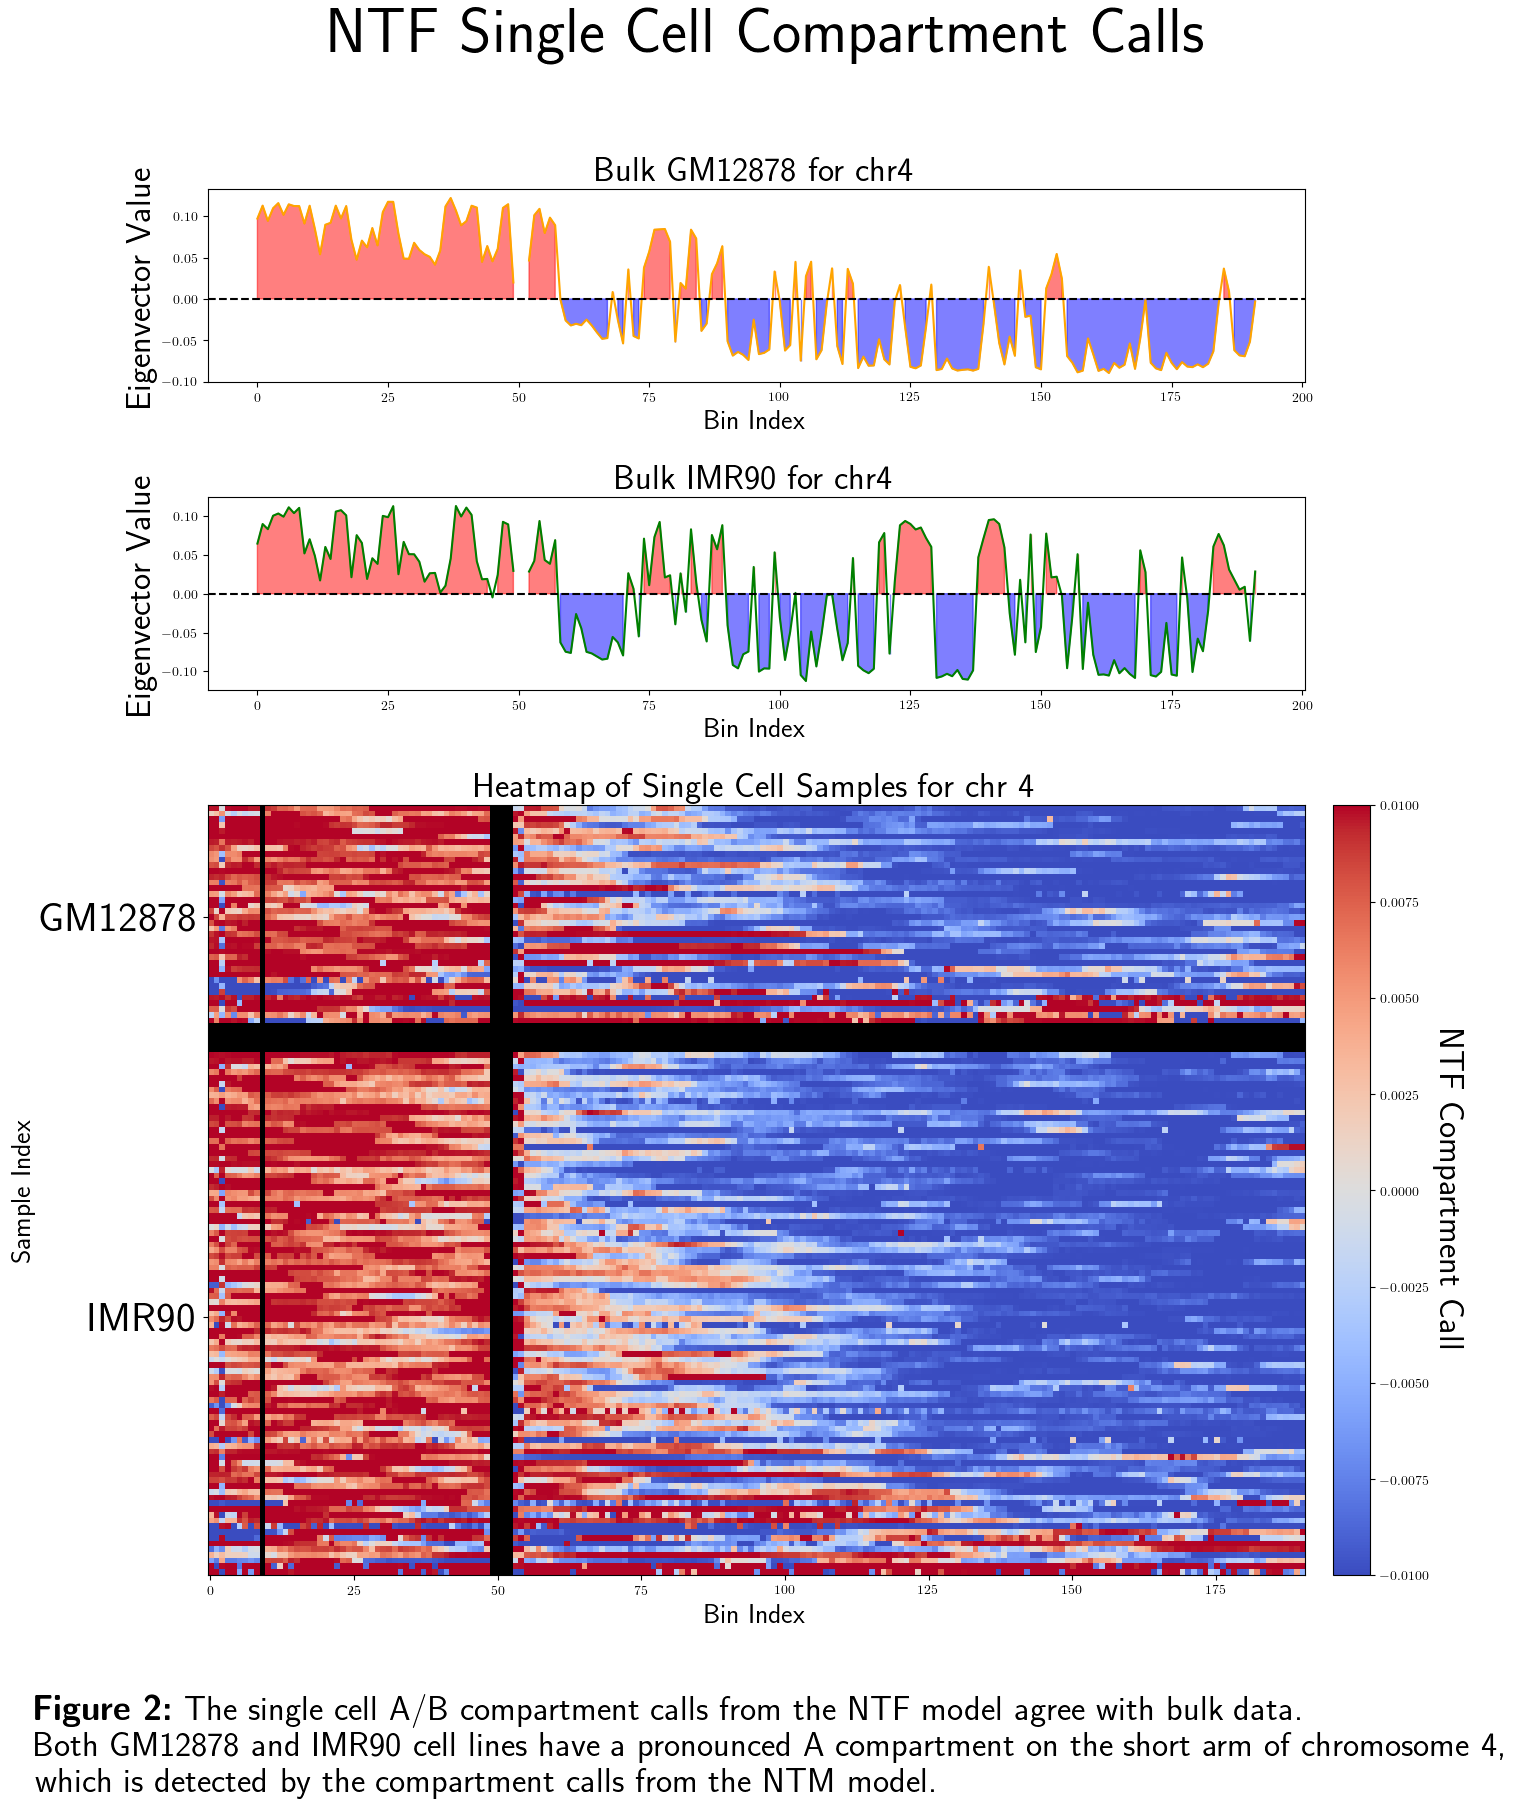

In [146]:
chr = 4
sc_dataframe = chromosome_results[f'chr{chr}']

# Define the bulk eigenvectors
bulk_eigenvector_gm12878 = original_bulk_data[f'res1000000_ch{chr}_oe_GM12878_{normalization}_eigenvector']['eigenvalue'].values
bulk_eigenvector_imr90 = original_bulk_data[f'res1000000_ch{chr}_oe_IMR90_{normalization}_eigenvector']['eigenvalue'].values

# Sort and prepare the dataframe
sc_dataframe['Cell Type Sort'] = sc_dataframe['Cell Type'].map({'GM12878': 0, 'IMR90': 1})
sc_dataframe = sc_dataframe.sort_values(by=['Cell Type Sort', 'Correlation With Bulk'], ascending=[True, False])
sc_dataframe.drop('Cell Type Sort', axis=1, inplace=True)

def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title, correlation, chr, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 18))  
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='orange')
    ax_bulk1.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 >= 0), color='red', alpha=0.5)
    ax_bulk1.fill_between(range(len(bulk_eigenvector1)), bulk_eigenvector1, where=(bulk_eigenvector1 < 0), color='blue', alpha=0.5)
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=25)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='green')
    ax_bulk2.axhline(0, color='black', linestyle='--')  # Add y = 0 line
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 >= 0), color='red', alpha=0.5)
    ax_bulk2.fill_between(range(len(bulk_eigenvector2)), bulk_eigenvector2, where=(bulk_eigenvector2 < 0), color='blue', alpha=0.5)
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=25)

    gm12878_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'GM12878']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    imr90_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'IMR90']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    
    empty_rows = np.full((separation_rows, gm12878_data.shape[1]), np.nan)
    sc_data_array = np.vstack([gm12878_data, empty_rows, imr90_data])

    # Create a colormap that does not include white for NaN values
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='black')  # Set NaN color to black

    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap=cmap, interpolation='nearest')  # Use the adjusted colormap
    ax_sc.set_title(f"Heatmap of Single Cell Samples for chr {chr}", fontsize=25)  # Slightly larger font for the title
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    num_gm12878 = len(gm12878_data)
    num_imr90 = len(imr90_data)
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('NTF Compartment Call', rotation=270, labelpad=25, fontsize=25)

    plt.suptitle(title, fontsize=45, fontweight='bold')  

    caption = (r"$\textbf{Figure 2:}$ The single cell A/B compartment calls from the NTF model agree with bulk data. " 
           f"Both GM12878 and IMR90 cell lines have a pronounced A compartment on the short arm of chromosome {chr}, "
           f"which is detected by the compartment calls from the NTM model."
          )

    # Use textwrap to wrap the caption text within a specific width
    wrapped_caption = textwrap.fill(caption, width=100)

    # Add the caption at the bottom with automatic wrapping
    plt.figtext(0.01, -0.01, wrapped_caption, wrap=True, horizontalalignment='left', fontsize=25)

    if save_path:
        # Ensure the save directory exists
        save_directory = os.path.dirname(save_path)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()    
    
# Example invocation with the genome-wide correlation value and chromosome number
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    f"Bulk GM12878 for chr{chr}",
    f"Bulk IMR90 for chr{chr}",
    "NTF Single Cell Compartment Calls",
    correlation=correlation,  # Use the computed correlation value here
    chr=chr,  # Use the chromosome number variable
    save_path=f"../../files/AB_compartment_heatmap_ch{chr}_example.png"
)
